### Planetscope preprocessing



This script:
- Reads multiple Planetscope images/scenes
- Convert TOA Radiance to TOA Reflectance
- Creates a composite image (or mosaic) that cover a selected area of interest (AOI).

Main packages are rasterio and fiona.

Code is based on notebooks from Planetlabs, available here: https://github.com/planetlabs/notebooks

Data used are from Planetscope 21. June 2019 over a selected study area in the Brazilian Amazon.

In [1]:
import numpy as np
import matplotlib
import rasterio
import fiona

#### Step 1. Aquire Imagery

#### Step 2. Read Images and Inspecting Imagery

In [2]:
# Will collect 7 scenes from 21. June 2019 to mosaic over AOI
# Reading image files(AnalyticMS) and adding the full path
n_images = 7
from os import walk
AnalyticMS_files = []
for (dirpath, dirnames, filenames) in walk('planet_21\AnalyticMS_files'):
    AnalyticMS_files.extend(filenames)
    break
AnalyticMS_path = []
for i in AnalyticMS_files:
    AnalyticMS_path.append('planet_21/AnalyticMS_files/' + i)
print(AnalyticMS_path)

['planet_21/AnalyticMS_files/20190721_133241_1034_3B_AnalyticMS.tif', 'planet_21/AnalyticMS_files/20190721_133242_1034_3B_AnalyticMS.tif', 'planet_21/AnalyticMS_files/20190721_133243_1034_3B_AnalyticMS.tif', 'planet_21/AnalyticMS_files/20190721_133316_1044_3B_AnalyticMS.tif', 'planet_21/AnalyticMS_files/20190721_133317_1044_3B_AnalyticMS.tif', 'planet_21/AnalyticMS_files/20190721_133318_1044_3B_AnalyticMS.tif', 'planet_21/AnalyticMS_files/20190721_133319_1044_3B_AnalyticMS.tif']


In [3]:
# Reading image metadata(AnalyticMS_metadata) and adding the full path
Analytic_meta_files = []
for (dirpath, dirnames, filenames) in walk('planet_21/Metadata_files'):
    Analytic_meta_files.extend(filenames)
    break
Analytic_meta_path = []
for i in Analytic_meta_files:
    Analytic_meta_path.append('planet_21/Metadata_files/' + i)
print(Analytic_meta_path)

['planet_21/Metadata_files/20190721_133241_1034_3B_AnalyticMS_metadata.xml', 'planet_21/Metadata_files/20190721_133242_1034_3B_AnalyticMS_metadata.xml', 'planet_21/Metadata_files/20190721_133243_1034_3B_AnalyticMS_metadata.xml', 'planet_21/Metadata_files/20190721_133316_1044_3B_AnalyticMS_metadata.xml', 'planet_21/Metadata_files/20190721_133317_1044_3B_AnalyticMS_metadata.xml', 'planet_21/Metadata_files/20190721_133318_1044_3B_AnalyticMS_metadata.xml', 'planet_21/Metadata_files/20190721_133319_1044_3B_AnalyticMS_metadata.xml']


In [4]:
# Loading images into list using rasterio
img_list = []
for image in AnalyticMS_path:
    img_list.append(rasterio.open(image))
print(img_list[0])
print(len(img_list))

# Manual example
# img1 = rasterio.open('planet_21/20190721_133318_1044/analytic_udm2/20190721_133318_1044_3B_AnalyticMS.tif')

<open DatasetReader name='planet_21/AnalyticMS_files/20190721_133241_1034_3B_AnalyticMS.tif' mode='r'>
7


At this point we can use rasterio to inspect the metadata of these three images. Specifically, in order to create a composite from these images, we want to verify that all three images have the same data type, the same coordinate reference systems and the same band count

In [5]:
for image in img_list:
    print(image.meta['dtype'], image.meta['crs'], image.meta['count'])
    
# Manual example
#print(img2.meta['dtype'], img2.meta['crs'], img2.meta['count'])

uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4


Let's take a closer look at what these bands contain:

In [6]:
# Read in color interpretations of each band in img1 - here we'll assume img2 and img3 have the same values
colors = [img_list[0].colorinterp[band] for band in range(img_list[0].count)]

# taking a look at img1's band types:
for color in colors:
    print(color.name)

blue
green
red
undefined


The fourth channel is a binary alpha mask: this is common in satellite color models, and can be confirmed in Planet's documentation on the PSSCene3Band product.

Now that we've verified all three satellite images have the same critical metadata, we can safely use rasterio.merge to stitch them together.

#### Step 3. Extract the Data from Each Spectral Band
In this step, Rasterio (a Python library for reading and writing geospatial raster datasets) will be used to open the raster images (the .tif files). 

Then data from the bands will be extracted and loaded into arrays for further manioulationwith Python's NumPy libary.

Note: in PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared.

In [7]:
# Using rasterio to read radiance values for the 7 images/scenes
band_blue_radiance = [0]*n_images
band_green_radiance = [0]*n_images
band_red_radiance = [0]*n_images
band_nir_radiance = [0]*n_images

for i in range(n_images):
    with rasterio.open(AnalyticMS_path[i]) as src:
        band_blue_radiance[i] = src.read(1)
    with rasterio.open(AnalyticMS_path[i]) as src:
        band_green_radiance[i] = src.read(2)
    with rasterio.open(AnalyticMS_path[i]) as src:
        band_red_radiance[i] = src.read(3)
    with rasterio.open(AnalyticMS_path[i]) as src:
        band_nir_radiance[i] = src.read(4)

#### Step 4. Extract the Coefficients
Before converting to reflectance, the conversion coefficients from the metadata file (the .xml file) must be extracted.

In [8]:
from xml.dom import minidom

# Gathering the coefficients for the 7 images/scenes
coeffs_list = [] 
for image in Analytic_meta_path:
    xmldoc = minidom.parse(image)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")
    
    # XML parser refers to bands by numbers 1-4
    coeffs = {} # Coefficients for each image/scene
    for node in nodes:
        band_nr = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if band_nr in ['1', '2', '3', '4']:
            i = int(band_nr)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    coeffs_list.append(coeffs)

Note that the coefficients are all of order 1e-5, and that the coefficient for NIR is significantly higher than the coefficient for blue. This is a big deal if your use case involves performing band math because a pixel with a NIR/blue ratio of 1.0 in the radiance image will have a NIR/blue ratio of 3.35/1.929=1.73 in the reflectance image.

Most spectral indices are defined in terms of reflectance, not radiance.

#### Step 5: Convert Radiance to Reflectance
Radiance is measured in SI units: $W/m^2$. Reflectance is a ratio from 0 to 1. The conversion is performed as a per-band scalar multiplication:

In [9]:
# Calculating reflectance from radiance and conversion coefficients
band_blue_reflectance = []
band_green_reflectance = []
band_red_reflectance = []
band_nir_reflectance = []

for i in range(n_images):
        band_blue_reflectance.append(band_blue_radiance[i] * coeffs_list[i][1])
        band_green_reflectance.append(band_green_radiance[i] * coeffs_list[i][2])
        band_red_reflectance.append(band_red_radiance[i] * coeffs_list[i][3])
        band_nir_reflectance.append(band_nir_radiance[i] * coeffs_list[i][4])

In [10]:
# Checking the results by taking a look at the min-max range of the radiance (before) vs reflectance (after)
# for the red band from the first image/scene
radiance_min, radiance_max = np.amin(band_red_radiance[0]), np.amax(band_red_radiance[0])
reflectance_min, reflectance_max = np.amin(band_red_reflectance[0]), np.amax(band_red_reflectance[0])

print("Red band radiance is from {} to {}".format(radiance_min, radiance_max))
print("Red band reflectance is from {} to {}".format(reflectance_min, reflectance_max))

Red band radiance is from 0 to 10839
Red band reflectance is from 0.0 to 0.28485077640094947


#### Step 6. Creating the Mosaic

In [11]:
# Merge returns the mosaic & coordinate transformation information
from rasterio.merge import merge
(mosaic, transform) = merge(img_list)

Using rasterio.plot (a matplotlib interface) to preview the results of our mosaic.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


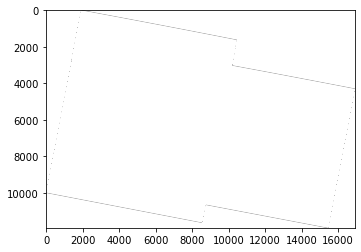

<AxesSubplot:>

In [12]:
from rasterio.plot import show
show(mosaic)

Before writing the mosaic out to a new GeoTIFF file, the metadata is taken from the first image/scene to represent the metadata of all input images.


In [13]:
# Copying metadata from image/scene 1
meta = img_list[0].meta

# Update the original metadata to reflect the specifics of our new mosaic
meta.update({"transform": transform,
    "height":mosaic.shape[1],
    "width":mosaic.shape[2]})

with rasterio.open('planet_21/21_mosaic.tif', 'w', **meta) as dst:
    dst.write(mosaic)

#### Step 7. Clip the Mosaic to AOI Boundaries
A mask is used to clip the mosaic to the extents of our area of interest (AOI).

For this operation rasterio's sister-library fiona will read in our AOI (as a GeoJSON file).
Just as rasterio is used to manipulate raster data, fiona works similarly on vector data. Where rasterio represents raster imagery as numpy arrays, fiona represents vector data as GeoJSON-like Python dicts.

After the GeoJSON is read, the geometry of the AOI is extracted, with the geometry as dict key.

##### A note about Coordinate Reference Systems

Before the AOI can be applied to the mosaic, the Coordinate Reference System (CRS) need to match.
This can be checked by reading the crs attribute of the Collection object generated by fiona.open().

The CRS of the AOI is: EPSG:4326.

While the CRS for the images/scenes is: EPSG:32722.


Before the clip can be applied, the geometry of the AOI needs to be transformed to match the CRS of the imagery.
Luckily, fiona is smart enough to apply the necessary mathematical transformation to a set of coordinates in order to convert them to new values: 
apply fiona.transform.transform_geom to the AOI geometry to do this, specifying the GeoJSON's CRS as the source CRS, and the imagery's CRS as the destination CRS.

In [14]:
# Checking CRS of image/scenes and the AOI
for image in img_list:
    print(image.meta['dtype'], image.meta['crs'], image.meta['count'])

aoi_info = fiona.open('planet_21/AOI/LCC_AOI.geojson')
aoi_info.crs

uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4


{'init': 'epsg:4326'}

In [15]:
# Using fiona on the vector data
import fiona

# Use fiona to open the original AOI GeoJSON
with fiona.open('planet_21/AOI/LCC_AOI.geojson') as mt:
    aoi = [feature["geometry"] for feature in mt]
    
# Transfrom LCC_AOI from CRS: EPSG:4326 to match mosaic CRS: EPSG:32722
from fiona.transform import transform_geom
transformed_coords = transform_geom('EPSG:4326', 'EPSG:32722', aoi[0])
aoi = [transformed_coords]

At this stage the AOI geometry is read and the coordinates have been transformed to match the mosaic.
Next, rasterio.mask.mask will create a mask over our mosaic, using the AOI geometry as the mask line.

Passing crop=True to the mask function will automatically crop the bits of our mosaic that fall outside the mask boundary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


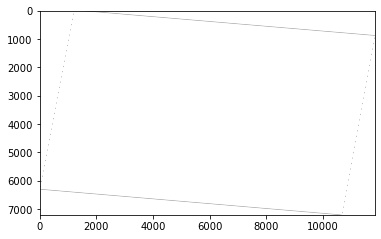

<AxesSubplot:>

In [16]:
# Import rasterio's mask tool
from rasterio.mask import mask

# Apply mask with crop=True to cut to boundary
with rasterio.open('planet_21/21_mosaic.tif') as mosaic:
    clipped, transform = mask(mosaic, aoi, crop=True)
    
# Watch the results
show(clipped)

#### Step 8. Export results
Lastly, the result is saved as a final output GeoTIFF.

In [17]:
# Use metadata from our original mosaic
meta = mosaic.meta.copy()

# Update metadata with new, clipped mosaic's boundaries
meta.update({"transform": transform,
    "height":clipped.shape[1],
    "width":clipped.shape[2]})

# Write the output to a GeoTIFF
with rasterio.open('planet_21/21_mosaic_clip.tif', 'w', **meta) as dst:
    dst.write(clipped)